In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [29]:
data = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')

In [30]:
data.head(2)

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635


In [31]:
data['FullDate'] = pd.to_datetime(data.FullDate)

In [32]:
data.set_index('FullDate', inplace=True)
data.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [33]:
data.shape

(92016, 4)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       92016 non-null  float64
 1   SysLoad    92016 non-null  float64
 2   GasPrice   92016 non-null  float64
 3   ElecPrice  92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB


In [35]:
fc = data

In [36]:
# hourly
dt_hourly = fc.resample('H').mean()

# daily
dt_daily = fc.resample('D').mean()

# weekly
dt_weekly = fc.resample('W').mean()

# monthly
dt_monthly = fc.resample('M').mean()

In [37]:
print(dt_hourly .shape)
print(dt_daily.shape)
print(dt_weekly.shape)
print(dt_monthly.shape)
     

(92016, 4)
(3834, 4)
(548, 4)
(126, 4)


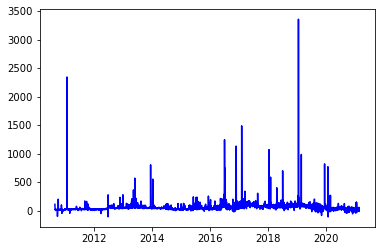

In [39]:
daily_rate = (dt_daily['ElecPrice'])
plt.plot(daily_rate , c='blue');

**Resampling the data (daily) and summing it up**

In [61]:
daily_fc = fc.resample('D')
new_fc = daily_fc.sum()
new_fc = new_fc.reset_index() 

In [42]:
new_fc.head(3)

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.38,88.56,2751.700
1,2010-09-02,369.6,38898.99,88.56,570.810
2,2010-09-03,439.2,41665.76,106.80,504.975


In [48]:
adf = adfuller(new_fc[ 'SysLoad'])
round(adf[1],6)

0.004254

In [49]:
adf_gas = adfuller(new_fc[ 'GasPrice'])
round(adf_gas[1],6)

0.045027

In [56]:
adf_elec = adfuller(new_fc[ 'ElecPrice'])
for i in [adf_gas[4], adf_elec[4]]:
    if i ==0:
            print('Critical Values for GasPrice')
            continue
    else:
        print('Critical Values for ElecPrice')
    
    for k, v in i.items():
        print( f' {k} : {round(v,4)} ' )

Critical Values for ElecPrice
 1% : -3.4321 
 5% : -2.8623 
 10% : -2.5672 
Critical Values for ElecPrice
 1% : -3.4321 
 5% : -2.8623 
 10% : -2.5672 


In [73]:
new_df = new_fc[['FullDate','ElecPrice']]
new_df =new_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
new_df.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


**Dataset Splitting**

In [74]:
fc_train = new_df.iloc[:2757]
fc_test  = new_df.iloc[2757:]

In [75]:
model = Prophet(daily_seasonality=True)
model.fit(fc_train)

04:55:56 - cmdstanpy - INFO - Chain [1] start processing
04:55:58 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
forecast = model.predict(fc_test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,4206.292139,47.769040,5039.952898,4206.292139,4206.292139,-1680.200871,-1680.200871,-1680.200871,-1524.929793,...,9.726912,9.726912,9.726912,-164.997989,-164.997989,-164.997989,0.0,0.0,0.0,2526.091268
1,2018-03-21,4207.075057,563.728698,5085.008899,4207.075057,4207.075057,-1527.705075,-1527.705075,-1527.705075,-1524.929793,...,159.367113,159.367113,159.367113,-162.142394,-162.142394,-162.142394,0.0,0.0,0.0,2679.369982
2,2018-03-22,4207.857974,505.744697,5160.163371,4207.857974,4207.857974,-1429.529405,-1429.529405,-1429.529405,-1524.929793,...,257.123600,257.123600,257.123600,-161.723211,-161.723211,-161.723211,0.0,0.0,0.0,2778.328569
3,2018-03-23,4208.640892,177.512868,4966.734512,4208.640892,4208.640892,-1638.226054,-1638.226054,-1638.226054,-1524.929793,...,50.278159,50.278159,50.278159,-163.574420,-163.574420,-163.574420,0.0,0.0,0.0,2570.414838
4,2018-03-24,4209.423810,73.214212,4800.089399,4209.423810,4209.423810,-1963.836810,-1963.836810,-1963.836810,-1524.929793,...,-271.453445,-271.453445,-271.453445,-167.453572,-167.453572,-167.453572,0.0,0.0,0.0,2245.587000


In [81]:
# Calculating the MAPE
true = fc_test['y']
pred = forecast['yhat']

def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return round(np.mean(np.abs((true - pred) / true)) * 100,2)

MAPE(true, pred)

542.39

In [83]:
mse = mean_squared_error(fc_test.y,forecast.yhat)
round(np.sqrt(mse),2)

3203.34

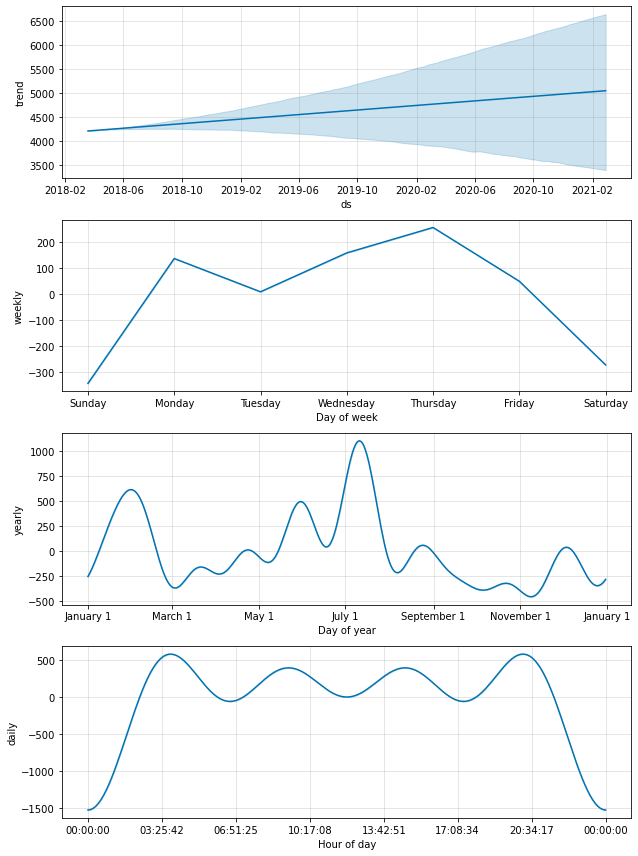

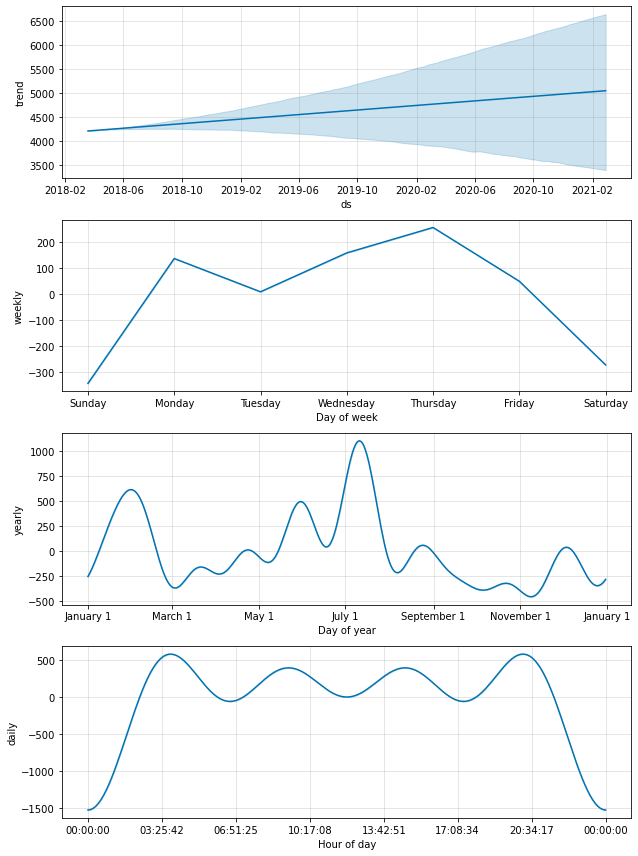

In [84]:
model.plot_components(forecast)

In [110]:
new_data["add1"] = new_fc['SysLoad']
new_data["add2"] = new_fc['Tmax']
new_data["add3"] = new_fc['GasPrice']

In [111]:
new_data.head(3)

,ds,y,add1,add3,add2
0,2010-09-01,2751.700,41565.38,88.56,379.2
1,2010-09-02,570.810,38898.99,88.56,369.6
2,2010-09-03,504.975,41665.76,106.80,439.2


In [87]:
fc_train = new_data.iloc[:2757]
fc_test  = new_data.iloc[2757:]

In [88]:
model2 = Prophet()
model2.add_regressor('add1')
model2.add_regressor('add2')
model2.add_regressor('add3')     

In [89]:
model2.fit(fc_train)

05:04:13 - cmdstanpy - INFO - Chain [1] start processing
05:04:15 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
forecast2 = model2.predict(fc_test)

In [91]:
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,1870.009895,-316.392364,4291.646794,1870.009895,1870.009895,-856.675764,-856.675764,-856.675764,0.235827,...,-84.499228,-84.499228,-84.499228,-39.259713,-39.259713,-39.259713,0.0,0.0,0.0,1988.500167
1,2018-03-21,1870.703675,-514.734607,4247.202630,1870.703675,1870.703675,-1026.747918,-1026.747918,-1026.747918,0.233029,...,42.534994,42.534994,42.534994,-29.964775,-29.964775,-29.964775,0.0,0.0,0.0,1979.861241
2,2018-03-22,1871.397454,606.343644,5103.337715,1871.397454,1871.397454,-215.033659,-215.033659,-215.033659,0.219471,...,145.611000,145.611000,145.611000,-24.925666,-24.925666,-24.925666,0.0,0.0,0.0,2900.370838
3,2018-03-23,1872.091234,338.455203,4858.966048,1872.091234,1872.091234,-274.992787,-274.992787,-274.992787,0.211509,...,-44.324251,-44.324251,-44.324251,-24.001000,-24.001000,-24.001000,0.0,0.0,0.0,2584.608469
4,2018-03-24,1872.785014,-780.636753,3587.448653,1872.785014,1872.785014,-1076.810544,-1076.810544,-1076.810544,0.209572,...,-117.530888,-117.530888,-117.530888,-26.940001,-26.940001,-26.940001,0.0,0.0,0.0,1437.598659


In [92]:
true = fc_test['y']
pred = forecast2['yhat']

def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return round(np.mean(np.abs((true - pred) / true)) * 100,2)

MAPE(true, pred)

233.05

In [93]:
mse = mean_squared_error(fc_test.y,forecast2.yhat)
round(np.sqrt(mse),2)

2708.86

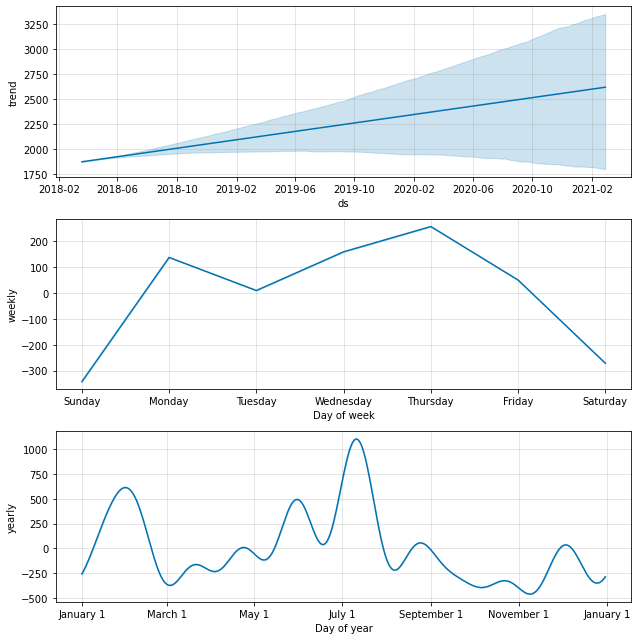

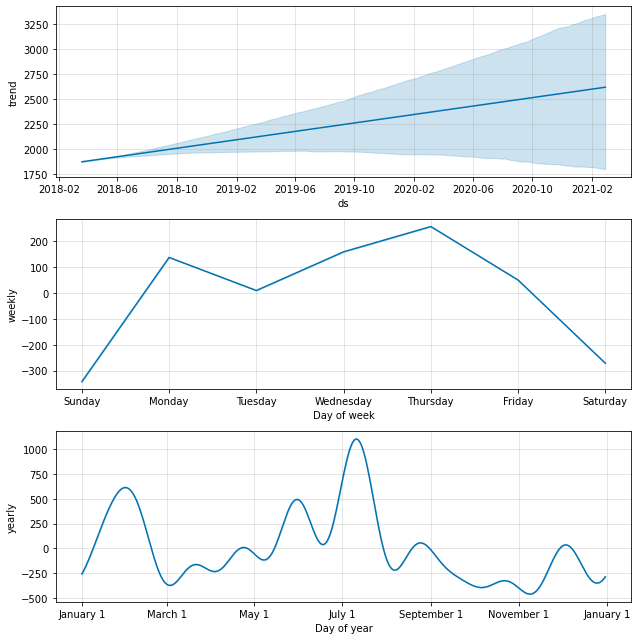

In [94]:
model.plot_components(forecast2)

In [95]:
new_data.head(3)

,ds,y,add1,add2,add3
0,2010-09-01,2751.700,41565.38,379.2,88.56
1,2010-09-02,570.810,38898.99,369.6,88.56
2,2010-09-03,504.975,41665.76,439.2,106.80


In [112]:
new_data = new_data.drop('add2', axis=1)

In [113]:
new_data.head(3)

,ds,y,add1,add3
0,2010-09-01,2751.700,41565.38,88.56
1,2010-09-02,570.810,38898.99,88.56
2,2010-09-03,504.975,41665.76,106.80


In [114]:
fc_train = new_data.iloc[:2757]
fc_test  = new_data.iloc[2757:]

In [115]:
model3 = Prophet(daily_seasonality=True)
model3.fit(fc_train)

05:13:22 - cmdstanpy - INFO - Chain [1] start processing
05:13:24 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
forecast3 = model3.predict(fc_test)

In [117]:
true = fc_test['y']
pred = forecast3['yhat']

def MAPE(true, pred): 
    true, pred = np.array(true), np.array(pred)
    return round(np.mean(np.abs((true - pred) / true)) * 100,2)

MAPE(true, pred)

542.39